# CLASSIFICATION OF R/SOURDOUGH POSTS PER FLAIR TAGS: 04 - K NEAREST NEIGHBORS

## 1) Introduction

### 1.1) General presentation: 

The aim of this project is to help predict the category of a post on the r/sourdough subreddit, based on its text content: its title, the content of the post itself and of the comments. More details on the general context of the project are provided in the first notebook : [01 - Exploratory Data Analysis](./01_exploratory_data_analysis.ipynb). 

The main strategy employed for the preprocessing of the data was a Bag-of-words approach, where the cleaning (cleaning, removing punctuation, numbers and  urls, lemmatization) and tokenization (splitting of the strings in smaller units; here words) was followed by counting each unique words to define the vocabulary. Then, each word was represented by its freqency in each post, pondered by its freqency in the whole corpus. The TF-IDF vectorizer was tuned to remove the noise(i.e.: words too frequent as well as words not frequent enough). 

In addition, posts categories were explored, and it was decided to regroup them in meta categories, as the large number of initial categories (40), paired with the large imbalance (some categories only having 1 observation, when others had  almost a thousand) would have lead to poor performance for the classifiers. 

Thus, the preprocessing resulted in two dataset: 
* A training set with 6713 observations and 1195 features that will be used to train our machine learning models through cross validation
* A test set with 2878 observations and 1195 features that will be used to test the performance of our models. 

The meta classes to predict, constructed based on insider knowledge of the r/sourdough subreddit are as follows: 
* Critique
* Discussion
* Help
* Look 

The Machine learning strategy for the project is as follows: 
1. Train multiple classifiers on the training set, using cross validation to tune the hyperparameters. These models, referred to as 0-level classifiers,  are: 
* Naive Bayes
* Logistic Regression
* K nearest neighbors
* Decision Tree
* Random Forest
* Support Vector Machine with a non linear kernel

2. Produce 5-folds out of bag predictions on the training set (divide the training set in 5 folds, fitting the optimal model on the first 4 folds to predict the fifth, repeat % times) from all 0-level classifiers and use these to perform a quick data exploration of the predictions. 

3. Stack the 0-level classifiers and train and fine tune the meta classifier. 

4. Evaluate all predictions(0-level and meta-classifier), by comparing their performance to a dummy classifier, using a stratified strategy (prediction randomly drawn from a distribution computed from the target variable distribution in the training set)

5. At the end of the process, we will discuss our results as well as the challenges we faced and the possible points of improvements that could be considered for the project. 

### 1.2) Aim of this notebook
This notebook aims at performing the training of a k-nnearest neighbor (knn) classifier to help categorize reddit posts on the r/sourdough subreddit. A knn classifier is a non-parametric classifier that assigns to an observation, the class that is the most common among its k nearest neighbors (k is a positive integer). 

At the end of this notebook, we will have achieved 3 things:

We will have tuned a knn Classifier and found the optimal set of hyper parameters using cross validation on our training set.
We will have computed predictions on the test set to evaluate the performance of our tuned model
We will have computed 5-folds predictions on the training set to use in our stacking strategy

### 2) Training the KNN classifier
Loading libraries and data
First, we load the data, as well as the optimal set of parameters for the TF-IDF vectorizer, as established in [01 - Exploratory Data Analysis](./01_exploratory_data_analysis.ipynb). 

In [1]:
# loading libraries

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
#try with  td-idf 
#load data
train_df = pd.read_csv('data/train/train_preprocessed_sourdough.csv', sep = '\t')
test_df = pd.read_csv('data/test/test_preprocessed_sourdough.csv', sep = '\t')
train_df.head()

,Unnamed: 0,Post ID_x,Subreddit,Title,OP Text,Permalink,Publish Date,Flair,Post ID_y,Body,Post ID2,standard_title,standard_op,standard_body,standard_text,Text,Publish Date Datetime,day,Flair_process,date_flag
0,4974,mxv8wb,Sourdough,My first loaf!,NaN,/r/Sourdough/comments/mxv8wb/my_first_loaf/,2021-04-25 01:02:04,Help! Rate/critique my bread,NaN,NaN,NaN,first loaf,NaN,NaN,first loaf,My first loaf!,2021-04-25 01:02:04,2021-04-25,Critique,Before 01.06.2021
1,2230,l1e53s,Sourdough,This one is a little better but still not grea...,NaN,/r/Sourdough/comments/l1e53s/this_one_is_a_lit...,2021-01-20 18:42:43,Newbie help,t3_l1e53s,6h in a cold apartment is not that long you kn...,l1e53s,one little well still great bulk ferment cold ...,NaN,h cold apartment long know h maybe try long bu...,one little well still great bulk ferment cold ...,This one is a little better but still not grea...,2021-01-20 18:42:43,2021-01-20,Help,Before 01.06.2021
2,9017,qo8d7r,Sourdough,It still amazes me that we can turn flour wate...,NaN,/r/Sourdough/comments/qo8d7r/it_still_amazes_m...,2021-11-06 21:18:54,Rate/critique my bread,t3_qo8d7r,"What kind of paper do you use?,Its a reusable ...",qo8d7r,still amaze turn flour water salt,NaN,kind paper use reusable parchment paper like t...,still amaze turn flour water salt kind paper ...,It still amazes me that we can turn flour wate...,2021-11-06 21:18:54,2021-11-06,Critique,After 01.06.2021
3,673,k9ymng,Sourdough,Joshua Weizmann starter method- day ten.,As common the first few days my starter was do...,/r/Sourdough/comments/k9ymng/joshua_weizmann_s...,2020-12-09 20:25:14,Newbie help,t3_k9ymng,Sounds like you just need to keep discarding a...,k9ymng,joshua weizmann starter method day ten,common first day starter double day ten slow m...,sound like need keep discard feed maybe twice ...,joshua weizmann starter method day ten common ...,Joshua Weizmann starter method- day ten. As co...,2020-12-09 20:25:14,2020-12-09,Help,Before 01.06.2021
4,3546,lsrho0,Sourdough,My first loaf with a starter I started just 1 ...,NaN,/r/Sourdough/comments/lsrho0/my_first_loaf_wit...,2021-02-26 07:12:56,Help,t3_lsrho0,"Recipe as follows, 90% KA bread flour 10% KA w...",lsrho0,first loaf starter start week ago kitchen big ...,NaN,recipe follow ka bread flour ka whole wheat sa...,first loaf starter start week ago kitchen big ...,My first loaf with a starter I started just 1 ...,2021-02-26 07:12:56,2021-02-26,Help,Before 01.06.2021


In [3]:
X_tr = train_df["standard_text"].values
X_te = test_df["standard_text"].values

In [4]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
y_tr = train_df["Flair_process"]
y_tr_enc = LE.fit_transform(y_tr)

y_te = test_df["Flair_process"]
y_te_enc = LE.transform(y_te)

In [5]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

#import best parameters for tf_idf
vec = open("./data/train/Tfidf_parameters.pickle", 'rb') # rb= read in bytes
tf_idf_search  = pickle.load(vec)
vec.close()
# Calculate TF-IDF
tf_idf = TfidfVectorizer(#max_features=tf_idf_search.best_params_['vect__max_features'],
                         min_df =tf_idf_search.best_params_['vect__min_df'], 
                         max_df = tf_idf_search.best_params_['vect__max_df'], 
                         use_idf = tf_idf_search.best_params_['vect__use_idf']
                        )

X_train_tfidf = tf_idf.fit_transform(X_tr)
X_test_tfidf = tf_idf.transform(X_te)

Wall time: 850 ms


#### Hyper-paramaters tuning 
In order to train our KNN classifier, we will define a grid of parameters. 
In this case, the three parameters that we will tune are: 
* k: the number of neighbors
* the weights function: wether all k neighbors have the same weighs or if they contribute more or less according to their distance to the point 
* the distance type: the metrics used to compute the distance: Manhattan or Euclidian


#### Classes imbalance
As established during the EDA, even after consolidating the classes, we still have some imbalances in the classes to predict. This can be an issue as classes with less samples, tend to be predicted less accurately. 
Our strategy to mitigate for this is thus: 
* Using the f1 score as the metrics  as it averages the precision and recall and is thus better fitted than the accuacy when there is imbalance in the dataset
* Using the smoothing parameter, as classes with less observation are less likely to encounter all words in training. 

A common strategy for classes imbalance is to perform either upsampling or downsampling: 
* Upsampling means increasing the size of the classes with less observations, by duplicating ramdom samples until we reach the size of the classes with the majority of observations. This method has the drawback of artificially reducing variability in the minority classes, even more so if the difference in size between the minority and majority classes is very important. 
* Downsampling means removing random observations in the majority classes until we reach the number of observations in the minority class. This method has the drawback of reducing the size of the dataset, and while classes with less observations tend to be predicted less accurately, if all classes have a small number of observations, then all predictions will be less accurate. 

Finally another strategy is to use a cost-sensitive approach. For this approach, the cost of prediction errors is taken into account during training, by weighing the parameters differently per class in order to give more importance to the correct predictions of the classes with less observations. A simple way of implementing this strategy is to adjust weights inversely proportionately to class frequencies in the input data. 
This is the genereal approach we used throughout the project, as it didn't further impact the dataset and could be implemented with almost all approaches. 

In the case of the KNN classifier, the ways to deal with imbalance is to tune the weight and distance parameters. Indeed, with the assumption that observations belonging in the same category are closer together, tuning the these parameters in order to give more weight to the closest neighbors than to the farthest ones, may help mitigate the unbalance in the classes distribution.   

#### Grid search
Next, we define and run the grid search to tune the KNN classifier:

In [6]:
# load the machine learning libraries: 
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.preprocessing import Normalizer

from matplotlib import pyplot
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report

In [7]:
np.random.seed(42)
folds = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 0)

In [8]:
# knn Classifier 
# Grid search with cross-validation
from sklearn.model_selection import GridSearchCV

# Logistic regression estimator
knn_estimator = Pipeline([
    ('knn',KNeighborsClassifier())
])


# Define a set of reasonable values
k_values = [10,20,30,40,50,60,70,80,90,100,150,200,300]
weights_functions = ['uniform', 'distance']
distance_types = [1, 2] # L1, L2 distances

# Define a grid of values
grid = {
    'knn__n_neighbors': k_values,
    'knn__weights': weights_functions,
    'knn__p': distance_types
}
scoring = {"f1_score": "f1_weighted"}

knn_gscv = GridSearchCV(knn_estimator, grid, cv=skf, 
                        scoring = "f1_weighted",
                        refit=True, 
                        return_train_score=True, verbose = 1, n_jobs = -1)



In [9]:
%%time
import warnings
from sklearn.exceptions import ConvergenceWarning

# Filter convergence warnings
warnings.simplefilter('ignore', ConvergenceWarning)

# Fit/evaluate estimator
knn_gscv.fit(X_train_tfidf, y_tr_enc)

# Collect results in a DataFrame
knn_results = pd.DataFrame({
    'n_neigbors': knn_gscv.cv_results_['param_knn__n_neighbors'],
    'weights': knn_gscv.cv_results_['param_knn__weights'],
    'p': knn_gscv.cv_results_['param_knn__p'],
    'mean_tr': knn_gscv.cv_results_['mean_train_score'],
    'mean_val': knn_gscv.cv_results_['mean_test_score'],
    'std_val': knn_gscv.cv_results_['std_test_score']
})

# Ten best combinations according to the mean test score
knn_results.sort_values(by='mean_val', ascending=False).head(10)

Fitting 5 folds for each of 52 candidates, totalling 260 fits
Wall time: 3min 43s


,n_neigbors,weights,p,mean_tr,mean_val,std_val
34,90,uniform,2,0.499569,0.482018,0.008970
30,80,uniform,2,0.500784,0.480995,0.004700
26,70,uniform,2,0.501576,0.480062,0.009138
35,90,distance,2,0.996501,0.477994,0.009087
38,100,uniform,2,0.496386,0.477968,0.009170
27,70,distance,2,0.996501,0.477495,0.009474
22,60,uniform,2,0.500933,0.477218,0.010592
31,80,distance,2,0.996501,0.476949,0.008743
23,60,distance,2,0.996501,0.476789,0.010938
39,100,distance,2,0.996501,0.476537,0.010517


As we can see, the best average of the training score during the cross validation is 48% for 90 neighbors, an uniform distribution on the weight for the samples and an euclidean distance (p=2).
Using a non uniform weight for the neighbors yielded a much better training f1-score in average (99%), however, it lead to overfitting and was not better than the uniform weights. 
Next, we fit a the model with the optimal hyperparameters a last time on the whole training set and use it to produce predictions on the test set. 

### 3) Predictions on the test set

#### Classification performance

In [10]:
best_knn_params = knn_results.iloc[knn_results['mean_val'].idxmax(), :]

In [11]:
# knn classifier on whole training + validation sets
knn_final = Pipeline([
    ('knn', KNeighborsClassifier(n_neighbors = best_knn_params['n_neigbors'], weights  = best_knn_params['weights'], p = best_knn_params['p']))
])

In [12]:
knn_final.fit(X_train_tfidf, y_tr_enc)

Pipeline(steps=[('knn', KNeighborsClassifier(n_neighbors=90))])

In [13]:
# Report test score

knn_accuracy = knn_final.score(X_test_tfidf, y_te_enc)
print('Test accuracy of a tuned knn classifier: {:.2f}%'.format(100*knn_accuracy))

from sklearn.metrics import f1_score
knn_f1score = f1_score(y_te_enc, knn_final.predict(X_test_tfidf), average = 'weighted')
print('Test weighted F1 score of a tuned knn classifier: {:.2f}%'.format(100*knn_f1score))

Test accuracy of a tuned knn classifier: 53.47%
Test weighted F1 score of a tuned knn classifier: 48.33%


In addition to the f1 score, we produce the classification report below:

In [14]:
 print(classification_report(y_te_enc, knn_final.predict(X_test_tfidf), target_names = LE.classes_))

              precision    recall  f1-score   support

    Critique       0.49      0.07      0.12       488
  Discussion       0.51      0.27      0.35       652
        Help       0.51      0.79      0.62       827
        Look       0.57      0.74      0.65       911

    accuracy                           0.53      2878
   macro avg       0.52      0.47      0.44      2878
weighted avg       0.53      0.53      0.48      2878



In addition to the f1-score, the report displays the precision, the recall as well as the accuracy. 
* The precision is the ratio of correctly predicted observations in a class to the total predicted observations in this classe. In other words, for a given Flair, how many of the observations predicted in this class actually belong to it. 
* The recall is the ratio of correctly predicted observations in a class to the total number of observations in this actual class. In other words, for a given Flair, how many of the observtaions belonging to it were correctly identified. 

Contrary, to other models in this project, Critique has a precision on par with the other categories, with 49% of the posts predicted as Critique, actually belonging to this category, vs (resp.) 51%, 51% and 57% for (resp.) Discussion, Help and Look. However, the recall is very low for Critique, with only 7% of the actual Critique posts being correctly predicted. Only 27% of the Discussion posts were correctly predicted, while Look and Help were the categories with the best recall, with 79% and 74% of their posts being correctly predicted.  

The confusion matrix below shows this by displaying the repartition of the predictions in each classe: 

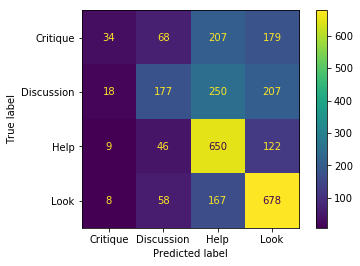

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(
        confusion_matrix(y_te_enc, knn_final.predict(X_test_tfidf)),
        display_labels=LE.classes_,
        #cmap=plt.cm.Blues,
        #normalize=True,
    ).plot()
#disp.ax_.set_title("Confusion matrix")

#print(title)
#print(disp.confusion_matrix)

plt.show()


While Help and Look posts are majoritarely predicted as their own categories, we can see that Critique and Discussion posts tend to be predicted as Look and Help pots.  



In order to identify if the issue with the misclassifications could stem from the way we regrouped the original flairs, we plot below how the original flairs are predicted: 

#### Classification vs original Flairs

In [16]:
crit_mask = y_te == "Critique"
disc_mask = y_te == "Discussion"
help_mask = y_te == "Help"
look_mask = y_te == "Look"

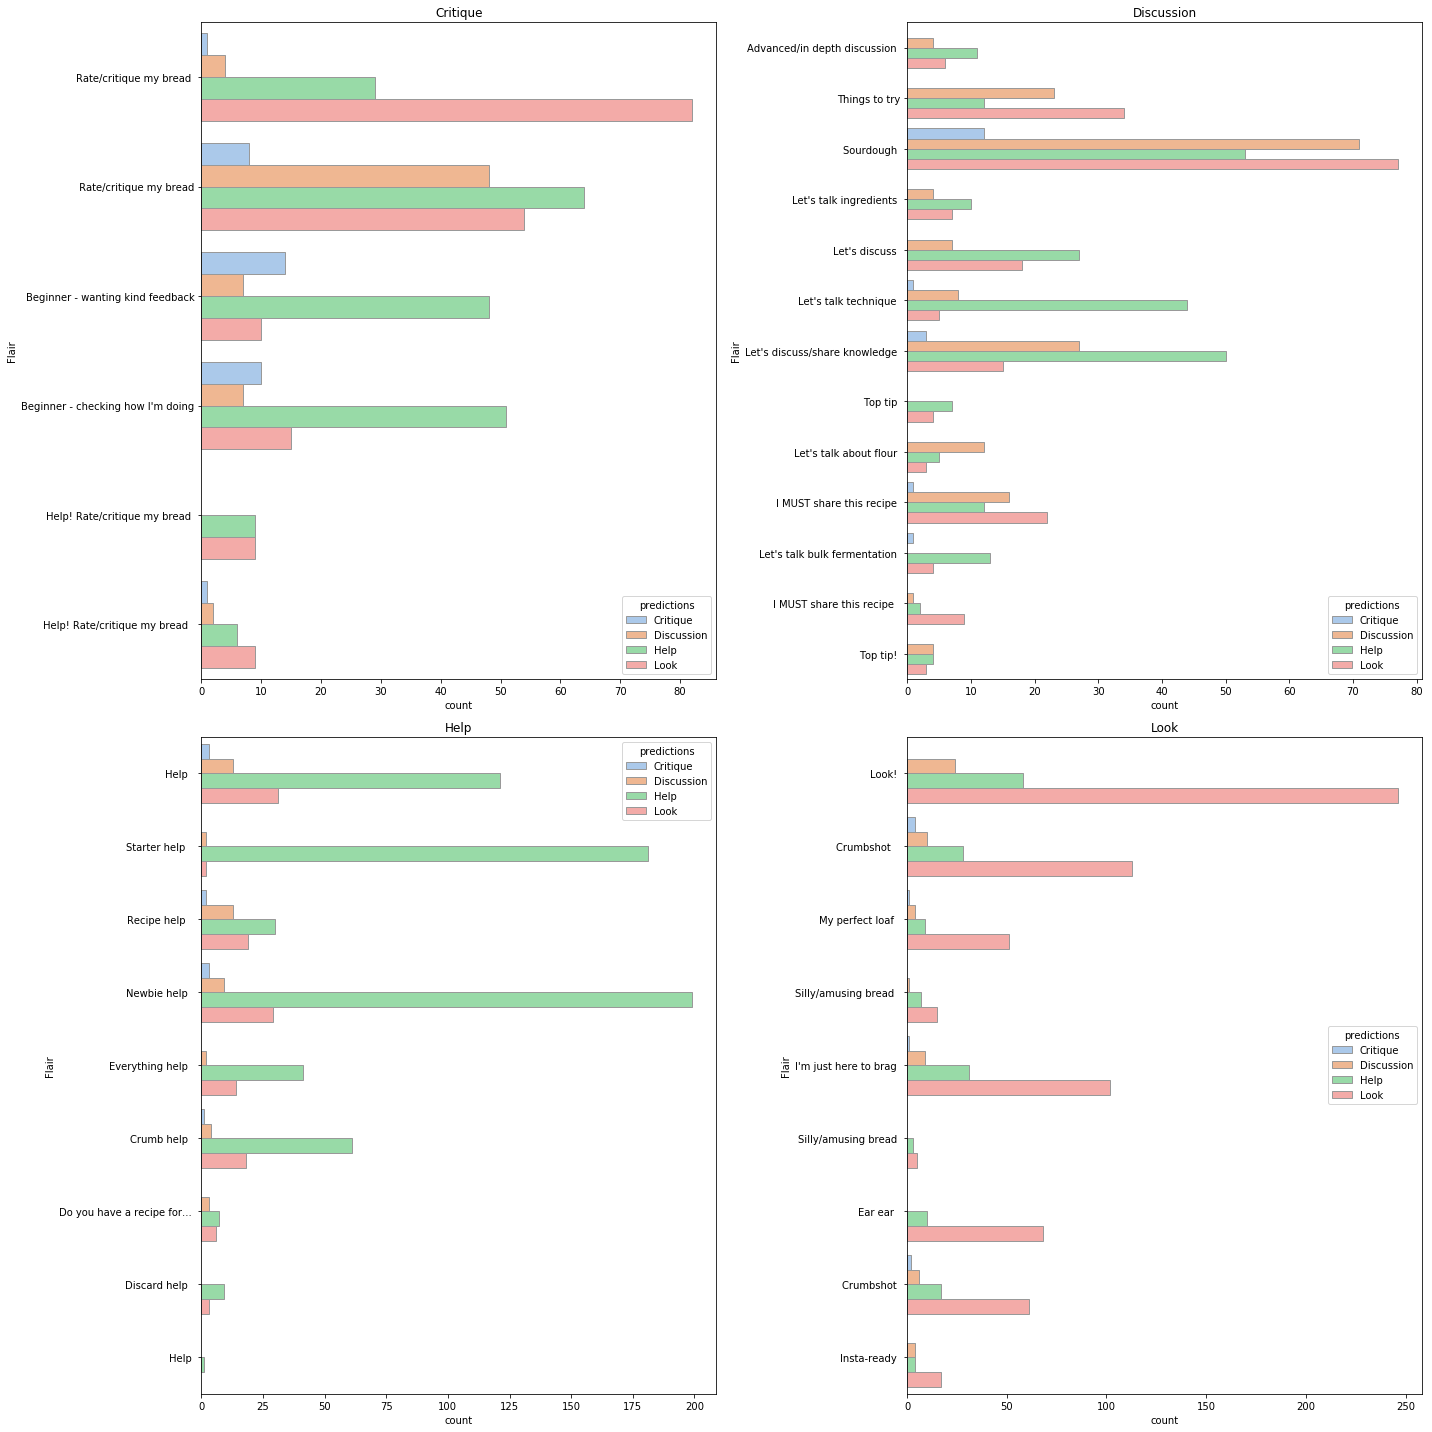

In [17]:
import seaborn as sns
crit_df = test_df.loc[crit_mask, :].copy()
crit_df["predictions"] = LE.inverse_transform(knn_final.predict(X_test_tfidf)[crit_mask])

disc_df = test_df.loc[disc_mask, :].copy()
disc_df["predictions"] = LE.inverse_transform(knn_final.predict(X_test_tfidf)[disc_mask])

help_df = test_df.loc[help_mask, :].copy()
help_df["predictions"] = LE.inverse_transform(knn_final.predict(X_test_tfidf)[help_mask])

look_df = test_df.loc[look_mask, :].copy()
look_df["predictions"] = LE.inverse_transform(knn_final.predict(X_test_tfidf)[look_mask])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols=2, sharex = False, sharey = False,  figsize=(20,20))

sns.catplot(y="Flair", hue="predictions", kind="count",
            palette="pastel", edgecolor=".6", hue_order = ["Critique", "Discussion", "Help", "Look"],
            data=crit_df, ax = ax1)
plt.close(plt.gcf())

sns.catplot(y="Flair", hue="predictions", kind="count",
            palette="pastel", edgecolor=".6", hue_order = ["Critique", "Discussion", "Help", "Look"],
            data=disc_df, ax = ax2)
plt.close(plt.gcf())

sns.catplot(y="Flair", hue="predictions", kind="count",
            palette="pastel", edgecolor=".6", hue_order = ["Critique", "Discussion", "Help", "Look"],
            data=help_df, ax = ax3)
plt.close(plt.gcf())

sns.catplot(y="Flair", hue="predictions", kind="count",
            palette="pastel", edgecolor=".6", hue_order = ["Critique", "Discussion", "Help", "Look"],
            data=look_df, ax = ax4)
plt.close(plt.gcf())

ax1.set_title("Critique")
ax2.set_title("Discussion")
ax3.set_title("Help")
ax4.set_title("Look")
plt.tight_layout()
plt.show()

We can see that for Posts in the Look category, it is very evident, that all original Flairs are majorly predicted as Look, as expected. The same goes for posts in the Help category, where a majority of the original flairs are predicted as Help. 

Regarding the other two categories, Critique and Discussion, the predictions are a bit messier. 

For Discussion, a lot of original flairs are mainly predicted as Help: "Let's discuss", "Let's talk technique", "Let's discuss/share knowledge", "Top tip", "Let's talk flour", "Let's talk bulk fermentation", "Let's talk ingredients". This would not be surprising as we can imagine that people struggling with some aspects of the baking process might want to launch a discussion on the subject. We can also see that a large majority of posts in the orignial flair "sourdough" are either misclassified as Look or Help. 

Finally, for the Critique category, no original flair has its posts mainly predicted as Critique. In addition, we can see that the two "Rate/critique my bread" have different distribution. 
For one of them, the majority of the posts are classified as Look instead of Critique, implying that the at some point the flair might have been used more as a way to show off photos of the bread. For the second "Rate/Critique my bread", all posts are almost equally distributed between Discussion, Help and Look. 

#### Top words to discriminate between Flairs

There is no way to easily display which features contribute the most to the distance between observations with a KNN classifier. A strategy to display this, would be to perform Permutation feature importance, where values in a single feature at a time are randomly shuffled. If the feature is important for the model, then, the score should decrease more than if a non important feature is shuffled. 
However, this is computationally expensive due to the large number of features in the data set and has thus been ignored for this project.  

### 3) Saving model 

Next, we produce out of folds productions on the training set: 
* split the training setin 5 folds
* fit the model on the first 4 folds
* compute predictions on the last fold 
* repeat for all of the 5 folds

These predictions will be used for a quick data exploration of the prediction before computing the stacking classifier. We compute both: 
* the flair prediction, in order to have a quick access to them to compute the correlation between the classification errors of all 0-level models before stacking
* the probability predictions, to use in a PCA. 

In [18]:
oof_knn_proba_pred = np.ndarray(shape = (0,4))
oof_knn_class_pred = []
oof_knn_true = []
for train_ix, test_ix in skf.split(X_train_tfidf, y_tr_enc):
    # get data
    train_X, test_X = X_train_tfidf[train_ix], X_train_tfidf[test_ix]
    train_y, test_y = y_tr_enc[train_ix], y_tr_enc[test_ix]
    # fit model
    knn_final.fit(train_X, train_y)
    # store predictions
    oof_knn_proba_pred = np.vstack((oof_knn_proba_pred, knn_final.predict_proba(test_X)))
    oof_knn_class_pred.append(knn_final.predict(test_X))
    oof_knn_true.append(test_y)
oof_knn_class_pred = np.concatenate(oof_knn_class_pred).ravel()
oof_knn_true = np.concatenate(oof_knn_true).ravel()

In [19]:
# save the model to disk
import pickle
filename = 'results/03_knn.sav'
pickle.dump([knn_final, oof_knn_proba_pred, oof_knn_class_pred, oof_knn_true], open(filename, 'wb'))